# Build a validation ndvi and weather dataset

In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np

data_path = '/mnt/e/DATA/DEV_inputs_test'

size = 10

# Original sets
ndvi_path = data_path + os.sep + 'ndvi_' + str(size) + '.nc'
rain_path = data_path + os.sep + 'rain_' + str(size) + '.tif'
ET0_path = data_path + os.sep + 'ET0_' + str(size) + '.tif'

# Validation sets
val_ndvi_path = data_path + os.sep + 'xls_NDVI_' + str(size) + '.nc'
rain_path = data_path + os.sep + 'xls_Rain_' + str(size) + '.tif'
val_ET0_path = data_path + os.sep + 'xls_ET0_' + str(size) + '.tif'

val_outputs = data_path + os.sep + 'xls_outputs_' + str(size) + '.nc'

# Modspa excel file
xls_file_path = '/home/auclairj/GIT/modspa-pixel/SAMIR_xls/SAMIRpixel_Reference_Simonneaux2012.xls'

In [2]:
# Get input data
modspa_excel = pd.read_excel(xls_file_path, sheet_name=0, header=10, index_col=0)
modspa_excel = modspa_excel.loc[:, ~modspa_excel.columns.str.contains('^Unnamed')]

# Dates
dates = modspa_excel.index

# Open empty dataset to get structure and reindex with correct dates
empty_dataset = xr.open_dataset(ndvi_path)
empty_dataset = empty_dataset.reindex(time = dates)

# Transpose dimensions
empty_dataset = empty_dataset.transpose('time', 'y', 'x')

# Get the numpy array for 'ndvi'
zero_values = empty_dataset['ndvi'].values

# Transpose the numpy array for 'ndvi'
zero_values = zero_values.transpose([0,2,1])
empty_dataset['ndvi'] = empty_dataset.ndvi.transpose('time', 'y', 'x')

# Assign the transposed numpy array back to 'ndvi'
empty_dataset.ndvi.values = zero_values

# Drop ndvi to get empty dataset
empty_dataset = empty_dataset.drop_vars('ndvi')

# Datasets
ndvi_val = empty_dataset.copy(deep = True)
rain_val = empty_dataset.copy(deep = True)
ET0_val = empty_dataset.copy(deep = True)
outputs_val = empty_dataset.copy(deep = True)

# Inputs
ndvi_val['NDVI'] = (empty_dataset.dims, np.zeros(tuple(empty_dataset.dims[d] for d in list(empty_dataset.dims)), dtype = 'uint8'))
rain_val['Rain'] = (empty_dataset.dims, np.zeros(tuple(empty_dataset.dims[d] for d in list(empty_dataset.dims)), dtype = 'uint16'))
ET0_val['ET0'] = (empty_dataset.dims, np.zeros(tuple(empty_dataset.dims[d] for d in list(empty_dataset.dims)), dtype = 'uint16'))

# Outputs
for var in modspa_excel.columns[0:-2]:
    outputs_val[var] = (empty_dataset.dims, np.zeros(tuple(empty_dataset.dims[d] for d in list(empty_dataset.dims)), dtype = 'int16'))

for x in ndvi_val.coords['x'].values:
    for y in ndvi_val.coords['y'].values:
        # Inputs
        ndvi_val['NDVI'].loc[{'x' : x, 'y' : y}] = np.round(modspa_excel['NDVI'].values * 255)
        rain_val['Rain'].loc[{'x' : x, 'y' : y}] = np.round(modspa_excel['Rain'].values * 1000)
        ET0_val['ET0'].loc[{'x' : x, 'y' : y}] = np.round(modspa_excel['ET0'].values * 1000)

        # Outputs
        for var in list(outputs_val.keys()):
            outputs_val[var].loc[{'x' : x, 'y' : y}] = np.round(modspa_excel[var].values * 100)

# Add precip
outputs_val['Rain'] = rain_val['Rain'].copy(deep = True) / 10

# Reorganize dimension order
ndvi_val = ndvi_val.transpose('time', 'y', 'x')
rain_val = rain_val.transpose('time', 'y', 'x')
ET0_val = ET0_val.transpose('time', 'y', 'x')

# Save datasets
# Inputs
ndvi_val.to_netcdf(val_ndvi_path, encoding = {"NDVI": {"dtype": "u1", "_FillValue": 0}})
rain_val.Rain.rio.to_raster(rain_path, dtype = 'uint16')
ET0_val.ET0.rio.to_raster(val_ET0_path, dtype = 'uint16')

# Create encoding dictionnary
for variable in list(outputs_val.keys()):
    # Write encoding dict
    encoding_dict = {}
    encod = {}
    encod['dtype'] = 'i2'
    encoding_dict[variable] = encod

# Outputs
outputs_val.to_netcdf(val_outputs, encoding = encoding_dict)


# Compare `modspa-pixel` and `modspa-excel` outputs

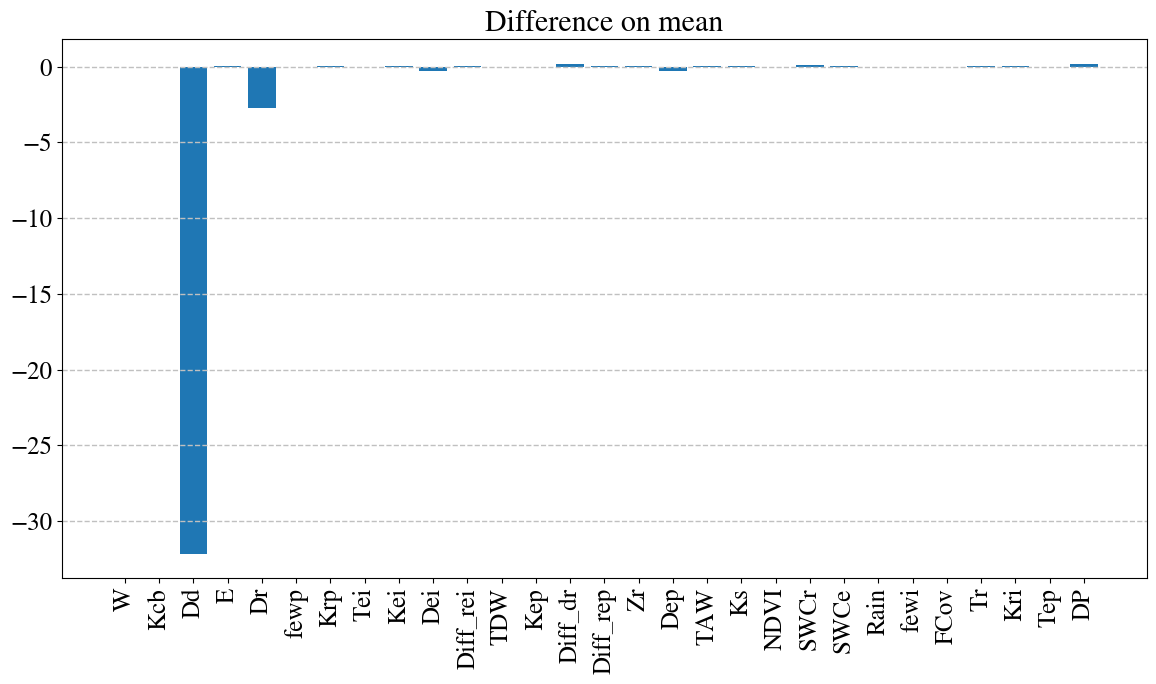

In [13]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates

# Settings for plots
plt.style.use('default')
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams.update({'font.size': 18})
# Date format
date_plot_format = mdates.WeekdayLocator(interval=6)
date_format = mdates.DateFormatter('%Y-%m')

def plot_time_series(ds1: xr.Dataset, var: str, ds2:xr.Dataset = None, label1: str = 'Dataset1', label2: str = 'Dataset2', scale_factor1: float = 1000, scale_factor2: float = 1000, unit: str = 'mm', title: str = 'variable comparison') -> None:
    """
    Plot times series of a uniform modspa dataset.
    Select first pixel (upper left corner) and plot
    its value over time.

    ## Arguments
    1. ds1: `xr.Dataset`
        first dataset to plot
    2. var: `str`
        name of variable to plot
    3. ds2: `xr.Dataset` `default = None`
        second dataset to plot, optional
    4. label1: `str` `default = 'Dataset1'`
        label for first dataset
    5. label2: `str` `default = 'Dataset2'`
        label for second dataset, optional
    6. scale_factor1: `float` `default = 1000`
        scale factor for first dataset to
        divide the time series in order to
        plot the correct variable values
    7. scale_factor2: `float` `default = 1000`
        scale factor for second dataset to
        divide the time series in order to
        plot the correct variable values
    8. unit: `str` `default = 'mm'`
        unit of value
    9. title: `str` `default = 'variable comparison'`
        title of plot

    ## Returns
    `None`
    """
    
    plt.figure(figsize = (14,7))
    plt.grid(color='silver', linestyle='--', axis = 'both', linewidth=1)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().xaxis.set_major_locator(date_plot_format)
    (ds1.isel(x = 0, y = 0)[var] / scale_factor1).plot(label = label1, color = 'b', alpha = 0.8)
    if ds2:
        (ds2.isel(x = 0, y = 0)[var] / scale_factor2).plot(label = label2, color = 'r', alpha = 0.8)
    plt.title(var + ' ' + title)
    plt.ylabel(var + ' [' + unit + ']')
    plt.legend()
    
    return None


data_path = '/mnt/e/DATA/DEV_inputs_test'

size = 10

# Inputs
rain_path = data_path + os.sep + 'xls_Rain_' + str(size) + '.tif'
ET0_path = data_path + os.sep + 'xls_ET0_' + str(size) + '.tif'

# Modspa-pixel output
pix_outputs_path = data_path + os.sep + 'pix_outputs_' + str(size) + '.nc'

# Excel output
xls_outputs_path = data_path + os.sep + 'xls_outputs_' + str(size) + '.nc'

# Open datasets
pix_outputs = xr.open_dataset(pix_outputs_path)
xls_outputs = xr.open_dataset(xls_outputs_path)
rain = xr.open_dataset(rain_path).rename({'band_data': 'rain', 'band': 'time'})
rain['time'] = pix_outputs.time.values
ET0 = xr.open_dataset(ET0_path).rename({'band_data': 'ET0', 'band': 'time'})
ET0['time'] = pix_outputs.time.values

# outputs = xr.where(outputs < 0, 0, outputs)

# Compute differences
variables = list(set(list(pix_outputs.keys())).intersection(set(list(xls_outputs.keys()))))
diff = pix_outputs.drop_vars(variables).copy(deep = True)
i = 0
for var in variables:
    if var in ['E', 'Tr', 'SWCe', 'SWCr', 'DP', 'Irr']:
        diff[var] = (pix_outputs[var].copy(deep=True) - xls_outputs[var].copy(deep=True) * 10) / 1000
    else:
        diff[var] = (pix_outputs[var].copy(deep=True) - xls_outputs[var].copy(deep=True)) / 100

# Get values
differences_sum = {}
differences_mean = {}
for var in variables:
    differences_sum[var] = round(float(diff[var].sum(dim = 'time').mean().values), 3)
    differences_mean[var] = round(float(diff[var].mean(dim = 'time').mean().values), 3)

# print('Difference on sum :', differences_sum)
# print('Difference on mean :', differences_mean)

plt.figure(figsize=(14, 7))
plt.grid(color='silver', linestyle='--', axis='y', linewidth=1)
plt.bar(range(len(differences_mean)), list(differences_mean.values()), align='center')
plt.xticks(range(len(differences_mean)), list(differences_mean.keys()), rotation='vertical')
plt.title('Difference on mean')
plt.show()

# plt.figure(figsize=(14, 7))
# plt.grid(color='silver', linestyle='--', axis='y', linewidth=1)
# plt.bar(range(len(differences_sum)), list(differences_sum.values()), align='center')
# plt.xticks(range(len(differences_sum)), list(differences_sum.keys()), rotation='vertical')
# plt.title('Difference on sum')
# plt.show()

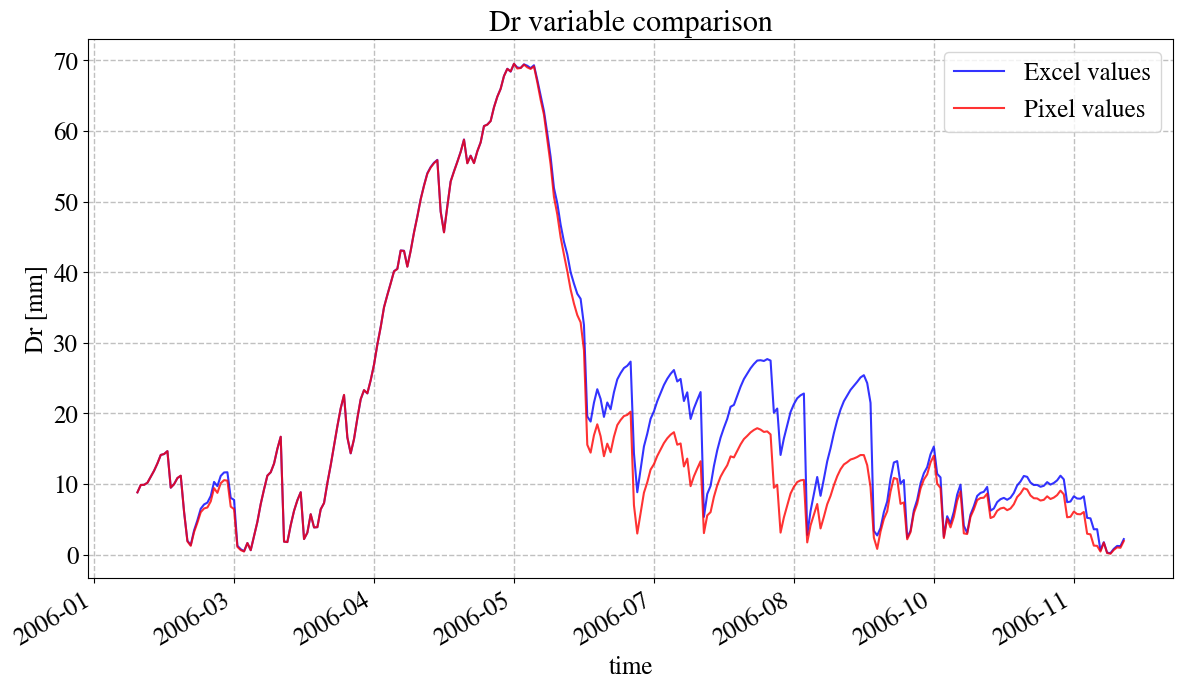

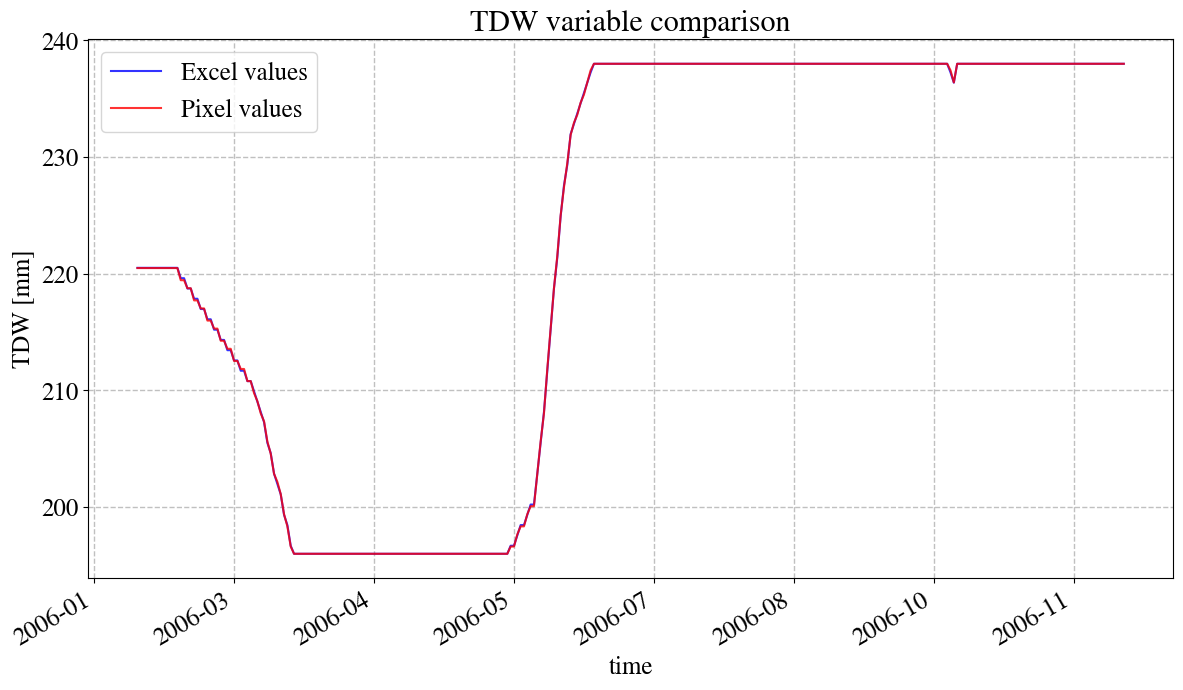

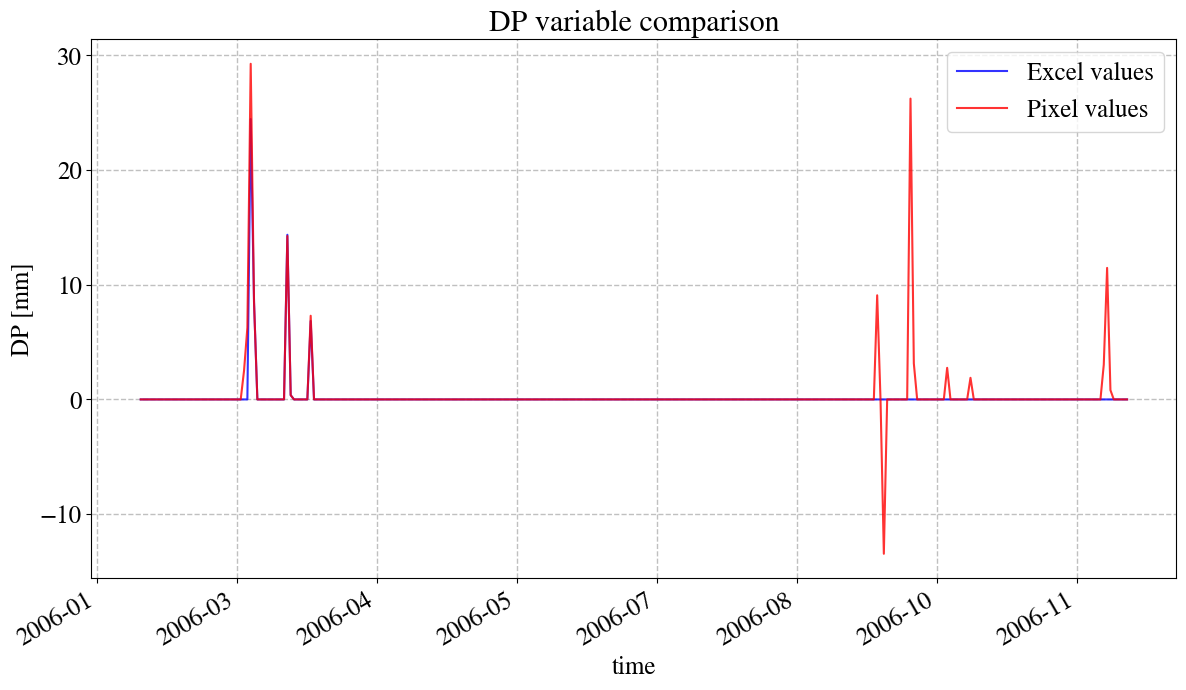

In [16]:
# Dataset pixel, Tr, E, SWCe, SWCr, Irr, DP : scale factor: 1000

plot_time_series(ds1 = xls_outputs, ds2 = pix_outputs, var = 'Dr', label1 = 'Excel values', label2 = 'Pixel values', scale_factor1 = 100, scale_factor2 = 100, unit = 'mm')
plot_time_series(ds1 = xls_outputs, ds2 = pix_outputs, var = 'TDW', label1 = 'Excel values', label2 = 'Pixel values', scale_factor1 = 100, scale_factor2 = 100, unit = 'mm')
plot_time_series(ds1 = xls_outputs, ds2 = pix_outputs, var = 'DP', label1 = 'Excel values', label2 = 'Pixel values', scale_factor1 = 100, scale_factor2 = 1000, unit = 'mm')

In [5]:
val_outputs

<xarray.Dataset>
Dimensions:      (x: 10, y: 10, time: 297)
Coordinates:
  * x            (x) float64 7e+05 7e+05 7e+05 ... 7.001e+05 7.001e+05 7.002e+05
  * y            (y) float64 4.7e+06 4.7e+06 4.7e+06 ... 4.7e+06 4.7e+06 4.7e+06
  * time         (time) datetime64[ns] 2006-02-06 2006-02-07 ... 2006-11-29
    spatial_ref  int64 ...
Data variables: (12/19)
    Kcb          (x, y, time) int16 ...
    Zr           (x, y, time) int16 ...
    TAW          (x, y, time) int16 ...
    TDW          (x, y, time) int16 ...
    Irr          (x, y, time) int16 ...
    DP           (x, y, time) int16 ...
    ...           ...
    W            (x, y, time) int16 ...
    Kei          (x, y, time) int16 ...
    Kep          (x, y, time) int16 ...
    E            (x, y, time) int16 ...
    Ks           (x, y, time) int16 ...
    Tr           (x, y, time) int16 ...

In [6]:
outputs

<xarray.Dataset>
Dimensions:      (x: 10, y: 10, time: 297)
Coordinates:
  * x            (x) float64 7e+05 7e+05 7e+05 ... 7.001e+05 7.001e+05 7.002e+05
  * y            (y) float64 4.7e+06 4.7e+06 4.7e+06 ... 4.7e+06 4.7e+06 4.7e+06
  * time         (time) datetime64[ns] 2006-02-06 2006-02-07 ... 2006-11-29
    spatial_ref  int64 ...
Data variables: (12/19)
    E            (x, y, time) int16 ...
    Tr           (x, y, time) int16 ...
    SWCe         (x, y, time) int16 ...
    SWCr         (x, y, time) int16 ...
    Irr          (x, y, time) int16 ...
    DP           (x, y, time) int16 ...
    ...           ...
    W            (x, y, time) int16 ...
    Kcb          (x, y, time) int16 ...
    fewi         (x, y, time) int16 ...
    fewp         (x, y, time) int16 ...
    TDW          (x, y, time) int16 ...
    TAW          (x, y, time) int16 ...